In [1]:
import os
import numpy as np
import librosa
from scipy.fftpack import dct

In [2]:
def manual_mfcc(y, sr, num_ceps=13, nfilt=26, NFFT=512):
    pre_emphasis = 0.97
    emphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    frame_length = int(0.025 * sr)
    frame_step = int(0.010 * sr)
    signal_length = len(emphasized)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_length - signal_length))
    padded = np.append(emphasized, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = padded[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)

    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = (1.0 / NFFT) * (mag_frames ** 2)

    low_mel = 0
    high_mel = 2595 * np.log10(1 + sr/2 / 700)
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    hz_points = 700 * (10**(mel_points/2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(NFFT/2 + 1)))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m-1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m+1])
        for k in range(f_m_minus, f_m):
            fbank[m-1, k] = (k - bin[m-1]) / (bin[m]-bin[m-1])
        for k in range(f_m, f_m_plus):
            fbank[m-1, k] = (bin[m+1]-k) / (bin[m+1]-bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfcc

In [5]:
healthy_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/Healthy"
polyp_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/Polyp"

features = []
labels = []

for folder, label in [(healthy_dir, 1), (polyp_dir, 0)]:
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            y, sr = librosa.load(path, sr=None)
            mfcc_feat = manual_mfcc(y, sr)
            mfcc_mean = np.mean(mfcc_feat, axis=0)
            features.append(mfcc_mean)
            labels.append(label)

features = np.array(features)
labels = np.array(labels)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (559, 13)
Labels shape: (559,)


In [6]:
!pip install gammatone

In [9]:
import numpy as np
import os
import librosa
import scipy.fftpack
from gammatone.gtgram import gtgram

healthy_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/Healthy"
polyp_dir = "/Users/manyasharma/FINAL_PROJECT_(POLYP)/Polyp"

all_gfcc = []
labels_gfcc = []

for folder, label in [(healthy_dir, 1), (polyp_dir, 0)]:
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            y, sr = librosa.load(file_path, sr=None)

            gt_spec = gtgram(y, sr, 0.025, 0.010, 64, 50)  
            log_gt = np.log(gt_spec + 1e-8)
            gfcc = scipy.fftpack.dct(log_gt, axis=0, norm='ortho')[:13, :]
            gfcc_mean = np.mean(gfcc, axis=1)

            all_gfcc.append(gfcc_mean)
            labels_gfcc.append(label)

all_gfcc = np.array(all_gfcc)
labels_gfcc = np.array(labels_gfcc)

print("GFCC features shape:", all_gfcc.shape)
print("Labels shape:", labels_gfcc.shape)

GFCC features shape: (559, 13)
Labels shape: (559,)


In [12]:
import pandas as pd

combined_features = np.hstack((features, all_gfcc))

combined_with_labels = np.hstack((combined_features, labels.reshape(-1, 1)))

mfcc_cols = [f"MFCC_{i+1}" for i in range(13)]
gfcc_cols = [f"GFCC_{i+1}" for i in range(13)]
all_cols = mfcc_cols + gfcc_cols + ["Label"]

df = pd.DataFrame(combined_with_labels, columns=all_cols)

df.to_csv("mfccgfcc_features.csv", index=False)
print("Saved features to mfccgfcc_features.csv")

Saved features to mfccgfcc_features.csv


In [15]:
import pandas as pd

data = pd.read_csv("/Users/manyasharma/FINAL_PROJECT_(POLYP)/mfccgfcc_features.csv")
print(data.head())

       MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -463.386072  -6.910735 -67.056706  35.017498  29.597116  25.817389   
1 -493.613498  79.770008   6.334841 -15.966239 -32.945780 -25.278355   
2 -516.419376  19.362922  61.526156  31.382111   4.664181  -7.581664   
3 -372.044242  20.030247  -5.038571  -4.317825 -56.802048  -9.911330   
4 -567.116999  -5.654256   5.697622  33.334170 -16.448778  13.379545   

      MFCC_7     MFCC_8     MFCC_9   MFCC_10  ...    GFCC_5    GFCC_6  \
0 -23.147953 -15.976043   8.663122 -5.442473  ... -1.312247 -3.956751   
1 -27.039437   3.233143  11.449448  5.436941  ... -3.970155 -1.334981   
2   2.346360  -4.566634 -10.610831  0.723224  ... -3.474085 -2.464387   
3 -11.995427  -2.644142  21.699035  1.893993  ... -5.935607  0.743181   
4 -10.336752 -11.147956   1.987888 -2.766518  ... -3.431878 -0.481482   

     GFCC_7    GFCC_8    GFCC_9   GFCC_10   GFCC_11   GFCC_12   GFCC_13  Label  
0 -4.551388  0.476773 -0.807015 -2.279852 -0.61

In [16]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values  

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid.predict(X_test_scaled)

print("Best parameters from GridSearch:", grid.best_params_)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Male","Female"]))

Best parameters from GridSearch: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Confusion Matrix:
[[53  3]
 [ 4 52]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.93      0.95      0.94        56
      Female       0.95      0.93      0.94        56

    accuracy                           0.94       112
   macro avg       0.94      0.94      0.94       112
weighted avg       0.94      0.94      0.94       112



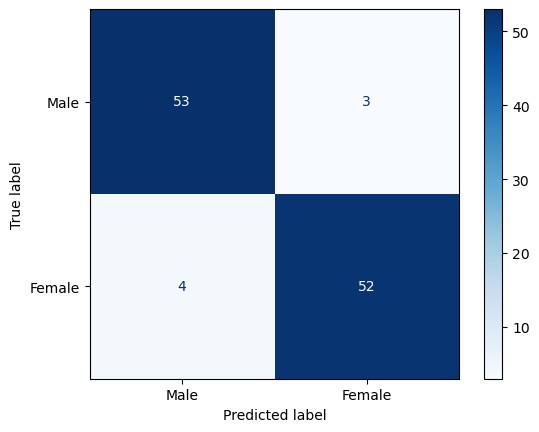

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
disp.plot(cmap="Blues", values_format="d")